# **(CloudPhysician) THE VITAL EXTRACTION CHALLENGE**

#***README File***
#Introduction
This collab notebook takes in the paths of images of different patient monitors, and outputs the values shown on the monitor, which are HR, SPO2, RR, SBP, DBP and MAP respectively. This notebook is made as a solution of the inter-IIT 2023 Problem Statement 6 - The Vital Extraction Challenge (By CloudPhysician)

#How to run
For the first time run, run the first block of 'Installing Necessities, Importing essential Libraries and models - '. It will load all the necessities into the memory, to be read for the inference function.
This block needs to be run only once, and it will take 20-30 seconds to run.

Also run all the blocks below the first block inorder to define the necessary functions.

**Note** - The SegmentationModel.h5 file present in the zip file should also be present in the Collab environment inorder for the notebook to run.

To run the functions, Run the inference function in the Final Function block. 

#Pipeline
Our Team divided the task into 2 subtasks - 


*   Finding the monitor in the image and cropping it.
*   Finding all the details on the monitor and finding which detail is which and generating the output accordingly.

For finding the monitor coordinates, we are using an deep CNN network, with an EfficientNetB4 backbone (pretrained imagenet weights). The model took in resized images from (1280,720) pixels to (380,380) pixels dimensions. We augmented the 2000 images of the segmentation dataset given to us, and created a dataset of 8000 images, and trained the model onto it. The rms error after training for 50 epochs, was 6.87, and validation rms error was 8.67.

The model is built, trained, and deployed via the keras API of tensorflow.

Also, the model is run on padded images (600 width, 338 height), inorder to give better accuracy on images which are really close to the edge of the image.

<img src = https://cdn.discordapp.com/attachments/1072573248493076563/1072573373495918632/output.png>

For finding all the details on the cropped Image, PaddleOCR is used. It detects all the text and the numbers present in the image, and stores it in a numpy array. It stores the word/number detected, the bounding box of the number detected and the confidence level of it.

<img>

After this, we use an algorithmic approach to find out all the relevant numbers - 


*   Firstly, we delete all the detections which are smaller than a minimum threshold value, inorder to eliminate noise from the detections.
*   Then we detect the HR in the image. We find any keywords equal or related to the word 'HR' (that might be present on the monitor) and print the closest integer to it. If no such word is found, we look at the numbers which are colored green, and print them out.If still not found we compare the respective values and take the topmost value finally.
*   By finding out the word SpO2 or similiar words and finding the numbers closest to it we get SpO2.
*   Similarly we find out the RR by looking for keyword 'rr','resp' and if not found we look for numbers under 45 and take them as RR. 
*   Then, we are using 4 different methods to detect BP and MAP in the image - 
    *   We first try to detect the BP by finding either '/' ad then if we get the value we are taking the first part as SBP and after '/' part as DBP.
    *   Our second attempt to find the BP is by looking for keywords like 'sys', '5y5', '5u5', 'dia', 'mmhg', 'winhg','nibp', 'nbp'. and then finding the nearest bounding boxes to it.
    *   We find Map by looking for '(' or ')'  and then if we got it we will take the numbers after '(' or before')'.If not found then we look for the keyword 'map' and find the bounding box nearest to it
    *   The last attempt to find out the BP and MAP is by looking for three numbers having closest distance and within distances  within a threshold and then trying to find the SBP,DBP and MAPs
*   After all that, we are simply arranging it all in a dictionary and outputting it.  
  




#Libraries used - 


*   Tensorflow (for running keras models)
*   OpenCV (for image processing)
*   PaddleOCR (for OCR functionality)
*   Numpy (for array calculations)
*   ColorThief (for finding dominant colors)
*   Matplotlib (for plotting HR graphs)
*   Deskew (for deskewing the original images)
*   NueroKit2 (for displaying HR graph from Heart rate)

#Installing Necessities, Importing essential Libraries and models -




In [ ]:
# !pip install numpy==1.21.6
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda create --name paddle_env python=3.8 --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/free/
# !source activate paddle_env
# !python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install paddlepaddle
!pip install paddleocr --upgrade
!pip install colorthief
!pip install neurokit2
!pip install deskew
# !pip install tensorflow
!pip cache purge

import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from deskew import determine_skew
from typing import Tuple, Union
from colorthief import ColorThief
from google.colab.patches import cv2_imshow
import math
from skimage import io
from skimage.color import rgb2gray
import neurokit2 as nk
from paddleocr import PaddleOCR

# Importing models
ocr = PaddleOCR(use_angle_cls=True, lang='en', enable_mkldnn=True)
!git clone https://github.com/ramsundar-tanikella/eff_net 
segmentationModel = tf.keras.models.load_model('/content/eff_net/efficientnetB4_2.h5')
segmentationModel.predict(np.zeros((1,380,380,3))) # To run it once so that weights get loaded into memory
print('done')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.5/385.5 KB 22.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.3 MB/s eta 0:00:

100%|██████████| 4.00M/4.00M [00:16<00:00, 245kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:23<00:00, 424kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:15<00:00, 145kiB/s]

[2023/02/11 15:39:55] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set

Cloning into 'eff_net'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (7/7), 689 bytes | 689.00 KiB/s, done.
1/1 [==============================] - 13s 13s/step
done


#Skew Correction, Padding, Segmentation and cropping

In [ ]:
# Skew Correction 

def deskewImage(image):
    imageGrayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    angle = determine_skew(imageGrayscale)
    deskewedImage = rotate(image, angle)
    deskewedImage = cv2.resize(deskewedImage, (1280,720))
    return deskewedImage

def rotate(image, angle):
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=(255,255,255))

**Reason for padding -** 

The images used for training the  model for segmentation are atleast 270 pixels away from the vertical edges. So, just for the model to work well on images which are very close to the vertical edges we have padded the image by 600 pixels horizontally(padding of 300 on each edge). As the images as padded by 600 pixels horizontally ,just to maintain the aspect ratio of the images we have padded the image by 338 pixels vertically (padding of 169 on each edge).

In [ ]:
# Padding

def pad(img):
    height, width = img.shape[:2]
    new_width = width + 600
    new_height = height + 338
    new_img = 255 * np.ones((new_height, new_width, 3), dtype="uint8")
    start_row = 169
    start_col = 300
    new_img[start_row:start_row + height, start_col:start_col + width, :] = img
    original_size = (1280, 720)
    img_resized = cv2.resize(new_img, original_size, interpolation=cv2.INTER_CUBIC)
    return img_resized

In [ ]:
# Main Segmentation function that will be called in inference()

def segmentation(imagepath):
    image = processImage(imagepath)
    image = deskewImage(image)
    image = pad(image)
    coordinates = giveCoordinates(image)
    croppedImage = croppingSegmentatedImages(coordinates, image)
    return croppedImage

def processImage(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def giveCoordinates(image):
    image = cv2.resize(image, (380, 380))
    expandedImage = np.expand_dims(image, axis=0)
    coordinates = segmentationModel.predict(expandedImage)
    coordinates = coordinates[0].astype(int)
    return coordinates

def croppingSegmentatedImages(coordinates, image):
    x1, y1, x2, y2, x3, y3, x4, y4 = coordinates
    top_left_x = min([x1,x2,x3,x4])
    top_left_y = min([y1,y2,y3,y4]) 
    bot_right_x = max([x1,x2,x3,x4]) + 20
    bot_right_y = max([y1,y2,y3,y4]) 
    
    height, width = image.shape[:2]
    new_width = width + 20
    new_height = height
    new_img = 255 * np.ones((new_height, new_width, 3), dtype="uint8")
    start_row = 0
    start_col = 10
    new_img[start_row:start_row + height, start_col:start_col + width, :] = image

    croppedImage = new_img[top_left_y:bot_right_y, top_left_x:bot_right_x]
    croppedImage = cv2.resize(croppedImage, (1280, 720))
    return croppedImage

#Basic Functions
Used to perform basic functions like displaying images, sorting coordinates, normalizing the image, string to integer conversion, whether string is integer or not etc.

In [ ]:
def removeAllText(result):
  bin = list()
  for x in result[0]:
    if(x[1][0].isdigit() == False ):
      bin.append(x)
  for x in bin:
    result[0].remove(x)
      
def removeBinElements(result, ignore_bin2, ignore_bin):
  bin = list()
  for x in ignore_bin2:
    if x in result[0] and x[1][0] in ignore_bin:
      # print(x[1][0])
      bin.append(x[1][0])
      result[0].remove(x)
  ignore_bin2.clear()
  for y in bin:
    ignore_bin.remove(y)

#Function to give font size
def boxSize(A):
  y = ([A[0][1], A[1][1], A[2][1], A[3][1]])
  y.sort()
  return y[3] - y[0]

#Taking the largest pixel in the box
def normalize(result):
  mx = 1
  for x in result[0]:
    if x[1][0].isdigit():
      mx = max( mx , boxSize(x[0]) )
  return mx

#A function to delete bounding boxes less than a particular threshold value
def threshDelete(thresh, mx, result):
  small_vals = list()
  for x in result[0]:
    if x[1][0].isdigit():
      if float(boxSize(x[0])/mx) <= thresh :
        small_vals.append(x)
  for y in small_vals:
    result[0].remove(y)

#String to integer
def stoi(string):
  x = 0
  string = str(string)
  for i in string :
    if i.isdigit():
      x = x * 10 + int( i )
  return x 

#Checks whether if particular element in the list is present in the string or not
def checkIfPresent(string, list):
  for y in list:
    if y in string.lower():
      return True
  return False

def isNumber1(string):
    for a in string:
      if(a.isalpha() == True and a != 'L'):
        return False
    return True 

#Ignoring some known character anomalies like '(',')','/' etc
def isNumber2 (string):
    for a in string:
        if((a.isalpha() == True)|(((a != '[')&(a != ']'))&(a != ')')&(a != '(')&(a != '/')&(a != ' ')&(a.isdigit() == False))):
            return False
    return True

#Finding the smallest two numbers of given 3 numbers
def find_smallest_two(a, b, c):
    if a <= b and a <= c:
        return a, min(b, c)
    elif b <= a and b <= c:
        return b, min(a, c)
    else:
        return [c, min(a, b)]

#formats the data
#ignoring known keywords like "ADULT"
#removing / in bp and ( ) in map
#evaluating sys and dia from bp
#checking whether map is in acceptable range of sys and dia
#removing erraneous characters from hr
def clear(icu_res):
  if "map" in icu_res:
    string = str(icu_res["map"])
    if "adu" in string.lower():
      pos = string.find("adu") - 3
      string = string[0:pos - 1]
      if string == "BO" or string == "8O" or string == "B0":
        string = "80"
    icu_res["map"] = stoi(string)
  if "bp" in icu_res:
    if "/" in icu_res["bp"]:
      string = icu_res["bp"]
      pos = string.find("/")
      pos2 = string.find("/",pos)
      if pos2 != -1:
        string = string[0:pos] + "/" + string[pos2+1:]
      res = ""
      for c in string:
        if c.isdigit() or c == '/':
          res += c
    else:
      string = icu_res["bp"]
      if( len(string) > 5 ):
        string = string[0:3] + "/" + string[4:]
      else:
        string = string[0:3] + "/" + string[3:]
      res = ""
      for c in string:
        if c.isdigit() or c == '/':
            res += c
    del icu_res["bp"]
    lst = res.split("/")
    if len(lst) > 0:
      icu_res["sys"] = lst[0]
    if len(lst) > 1:
      x = lst[1][0:3]
      if len(x) > 2 and x[0] >= '6':
        x = x[0:2]
      if len(x) > 2 and x[0] >= '2':
        x = x[1:]
      icu_res["dia"] = x 
  if "sys" in icu_res and "dia" in icu_res :
    if( stoi( str(icu_res["sys"])) < stoi(str(icu_res["dia"]))  ):
        temp = icu_res["sys"]
        icu_res["sys"] = icu_res["dia"]
        icu_res["dia"] = temp 
  if "sys" in icu_res and "dia" in icu_res and "map" in icu_res and icu_res["sys"] != "" and icu_res["dia"] != "":
    ideal = int( int(icu_res["sys"])/3 + 2*int(icu_res["dia"])/3 )
    if icu_res["map"] < ideal - 13 or icu_res["map"] > ideal + 13 :
      icu_res["map"] = str(ideal)
  if "map" not in icu_res or icu_res["map"] == "" :
    icu_res["map"] = str(int( int(icu_res["sys"])/3 + 2*int(icu_res["dia"])/3 ))
  if "hr" in icu_res:
    valuex = str(icu_res["hr"])
    if len( valuex ) > 2 and valuex[0] > '2' :
      icu_res["hr"] = valuex[0:2]
    else:
      icu_res["hr"] = valuex[0:3]
  if 'spO2' in icu_res:
    if stoi(icu_res['spO2']) < 50:
      icu_res['spO2'] = ''
  if 'rr' in icu_res:
    if stoi(icu_res['rr']) > 50:
      icu_res['rr'] = ''

# In this function we make all the desired values to match with the sample format 
def capitalise_keys (icu_res):
  if "hr" in icu_res:
    icu_res["HR"] = str(icu_res["hr"])
    del icu_res["hr"]
  else:
    icu_res["HR"] = ""
  if "spo2" in icu_res:
    icu_res["SPO2"] = str(icu_res["spo2"])
    del icu_res["spo2"]
  else:
    icu_res["SPO2"] = ""
  if "rr" in icu_res:
    icu_res["RR"] = str(icu_res["rr"])
    del icu_res["rr" ]
  else:
    icu_res["RR"] = ""
  if "sys" in icu_res:
    icu_res["SBP"] = str(icu_res["sys"])
    del icu_res["sys"]
  else:
    icu_res["SBP"] = ""
  if "dia" in icu_res:
    icu_res["DBP"] = str(icu_res["dia"])
    del icu_res["dia"]
  else:
    icu_res["DBP"] = ""
  if "map" in icu_res:
    if stoi(icu_res["map"]) == 0:
      icu_res["map"] = ""
    icu_res["MAP"] = str(icu_res["map"])
    del icu_res["map"]
  else:
    icu_res["MAP"] = ""
  if "map_confid" in icu_res:
    del icu_res["map_confid"]

#Geometric Functions
Functions used to find out geometric details of image.
Example,
- Distance between two segments
- Whether two segments intersect in a plane or not
- Distance between points and segments
- Shortest distance between two Bounding Boxes
- Find 3 closest Bounding boxes


In [ ]:
#Shortest Distance between two line segments 
def segments_distance(x11, y11, x12, y12, x21, y21, x22, y22):
  """ distance between two segments in the plane:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): return 0
  # try each of the 4 vertices w/the other segment
  distances = []
  distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
  distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
  distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
  distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
  return min(distances)

#Check whether two segments intersect or not
def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
  """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  dx1 = x12 - x11
  dy1 = y12 - y11
  dx2 = x22 - x21
  dy2 = y22 - y21
  delta = dx2 * dy1 - dy2 * dx1
  if delta == 0: return False  # parallel segments
  s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
  t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
  return (0 <= s <= 1) and (0 <= t <= 1)

#Shortest distance of a point from a segment
def point_segment_distance(px, py, x1, y1, x2, y2):
  dx = x2 - x1
  dy = y2 - y1
  if dx == dy == 0:  # the segment's just a point
    return math.hypot(px - x1, py - y1)

  # Calculate the t that minimizes the distance.
  t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

  # See if this represents one of the segment's
  # end points or a point in the middle.
  if t < 0:
    dx = px - x1
    dy = py - y1
  elif t > 1:
    dx = px - x2
    dy = py - y2
  else:
    near_x = x1 + t * dx
    near_y = y1 + t * dy
    dx = px - near_x
    dy = py - near_y

  return math.hypot(dx, dy)

#Shortest distance between two bounding boxes
def shortest_distance_between_two_bounding_boxes (A, B):
  ans = -1
  for i in range(4):
      X1 = A[i]
      Y1 = A[ ( i + 1 )%4 ]
      a = np.array([X1[0], X1[1]])
      b = np.array([Y1[0], Y1[1]])
      for j in range(4):
          X2 = B[j]
          Y2 = B[(j+1)%4]
          c = np.array([X2[0], X2[1]])
          d = np.array([Y2[0], Y2[1]])
          dist = segments_distance( a[0] , a[1] , b[0] , b[1] , c[0] , c[1] , d[0] , d[1] );
          if (( ans == -1 )|(ans > dist )):
              ans = dist
  return ans

#Finding the shortest distance between given three bounding boxes
def find3closest (A, B, C):
  x = shortest_distance_between_two_bounding_boxes( A , B )
  y = shortest_distance_between_two_bounding_boxes( A , C )
  z = shortest_distance_between_two_bounding_boxes( B , C )
  res = [ x , y , z ]
  res.sort()
  return res

#***Detecting Specific Values***

Here we have the following functions to detect the respective vitals
- solvebpfirst1 : to find BP
- solvebpfirst2 : to find BP and MAP using Keywords
- solveMapnotfound : to find out MAP if not found till now
- solvebplast   : last attempt to find the BP value using ditance logic
- detect_rr : Detects RR based on RR keyword
- detect_hr : Detects HR based on keyword
- detect_hr_color : Checks the color of HR and if it is in green range then we accept the value as HR.
- detect_spo2 : Detects SPO2 based on keywords of spo2 
- check_hr_color_range : checks the range of green color

In [ ]:
#First logic to find the BP 
def solvebpfirst1(thresh, icu_res, result, maxElSize, ignore_bin2, ignore_bin):
  # print("bp1")
  removeBinElements(result, ignore_bin2, ignore_bin)
  bp = str()
  mp = str()
  map_bin = list()
  for x in result[0]:
      if isNumber2(x[1][0]):
          #If length of numeric string is greater than 7 then we find BP and MAP
          if( len(x[1][0]) > 7 ):
            #Check whether opening bracket is present 
            ans = x[1][0]
            if "(" in x[1][0]:
                ans = x[1][0].split("(")
                bp = ans[0]
                mp = ans[1]
                ignore_bin2.append(x)
            else:
                bp = ans[0:5]
                mp = ans[5:]
                ignore_bin2.append(x)
          #Checking if the length is >=5 and <7 and try to detect '/' to find BP
          elif( len(x[1][0]) >= 5 )&( "/" in x[1][0] )and( boxSize(x[0]) >= 0.4*maxElSize ):
              bp = x[1][0]
              ignore_bin2.append(x);
              for y in result[0]:
                  #Trying to find MAP using opening or closing bracket and confidence of the text detector
                  if (y != x)&( isNumber2( y[1][0] )) :
                      if( "(" in y[1][0] or ")" in y[1][0] or "[" in y[1][0] or "]" in y[1][0]):
                          if( "map_confid" not in icu_res or icu_res["map_confid"] < y[1][1] ):
                            mp = y[1][0]
                            icu_res["map_confid"] = y[1][1]
                            map_bin = y
                      #If the shortest distance between BP and number is less than a threshold then we find MAP
                      if( shortest_distance_between_two_bounding_boxes( x[0] , y[0] ) < 40 ):
                          if( "map_confid" not in icu_res or int(icu_res["map_confid"]) < 60 ):
                            mp = y[1][0]
                            icu_res["map_confid"] = y[1][1]
                            map_bin = y
          #Assuming / is not detetcted
          elif( len(x[1][0]) >= 5 and boxSize(x[0]) >= 0.4*maxElSize ):
            ignore_bin.append(x)
            return [ x[1][0] , "" ]
          #For length less than equal to 4 and / is detected
          #If '/' is detected it is probably SysBP or DiaBP
          elif( "/" in x and len(x) < 4 and boxSize(x[0]) >= 0.4*maxElSize ):
            bp = x[1][0]
            distances = list()
            for y in result[0]:
              if (x != y)&(isNumber2(y[1][0])):
                #Trying to find two closest numeric bounding boxes and sorting it. 
                distances.append( ( shortest_distance_between_two_bounding_boxes( x[0] , y[0] ) , y  ))
            distances.sort()
            #Pressure is the value of bounding boxes satisfying the threshold
            pressure = list()
            for i in range(3):
              if( distances[i][0] <= thresh ):
                #Checking if there are bounding boxes which are satisfying our threshold
                pressure.append( ( stoi(distances[i][1][1][0]) , distances[i][1] ) )
              else:
                break
            pressure.sort()
            #Finding MAP and SysBP/DiaBP from pressure
            if( len( pressure ) >= 1 ):
              rs = [ stoi(bp) , stoi(pressure[0][0]) ]
              rs.sort()
              bp = str(rs[1]) + "/" + str(rs[0])
              map_bin = [ x , pressure[0][1] ]

      if bp != "":
        break
  #Ignoring found values for further ananlysis
  if len(map_bin) > 0:
    ignore_bin2.append(map_bin)
  return [ bp , mp ]

#Second attempt to find BP and MAP using Keyword recognition
def solvebpfirst2(thresh, thresh1, result, ignore_bin2, ignore_bin):
  # print("bp2")
  removeBinElements(result, ignore_bin2, ignore_bin)
  bp1 = str()
  bp2 = str()
  mp = str()
  bp_bin = list()
  for i in range(len(result[0])-1,0,-1):
    x = result[0][i]
    #Checking whether any of the following keyword is present in the string 
    if checkIfPresent(x[1][0] , [ 'sys' , '5y5' , '5u5' , 'dia' , 'mmhg' , 'winhg','nibp', 'nbp']):
      distances = list()
      for y in result[0]:
        if isNumber2( y[1][0] ) :
          #Finding the closest numeric bounding box to the keyword 
          distances.append( ( shortest_distance_between_two_bounding_boxes( x[0] , y[0] ) , y  ))
      distances.sort()
      distances2 = list()
      #Whether the nearest number is less farther than the threshold  
      if distances[0][0] < thresh:
        #Finding Two closest numbers near to the number detected closest to the keyword
        for z in result[0]:
          if isNumber2( z[1][0] ) and ( z != distances[0][1] ) :
            distances2.append( ( shortest_distance_between_two_bounding_boxes( z[0] , distances[0][1][0] ) , z ) )
        distances2.sort()
        pressure = list()
        #Finding two closest numbers
        for i in range(2):
          if i == len(distances2):
            break;
          if( distances2[i][0] <= thresh1 ):
            pressure.append(( stoi(distances2[i][1][1][0]) , distances2[i][1] ))
          else:
            break
        pressure.append(( stoi(distances[0][1][1][0]) , distances[0][1] ))
        pressure.sort()
        #Detecting BP and Map from this by value of sys>Map>dia
        if( len(pressure) == 1 ):
          bp2 = str(pressure[0][0])
          bp_bin = [ pressure[0][1] ]
        elif( len(pressure) == 2 ):
          bp2 = str(pressure[0][0])
          bp1 = str(pressure[1][0])
          bp_bin = [ pressure[0][1] , pressure[1][1] ]
        elif( len(pressure) > 2 ):
          bp2 = str(pressure[0][0])
          mp = str(pressure[1])
          bp1 = str(pressure[2][0])
          bp_bin = [ pressure[0][1] , pressure[1][1] , pressure[2][1] ]
  #Ignoring found numbers in further analysis
  for x in bp_bin:
    ignore_bin2.append(x)
  return [bp1,bp2,mp]



# CHECK FROM HERE



#Trying to find MAP first using brackets
def solveMapNotFound (icu_res, thresh, thresh1, result, ignore_bin2, ignore_bin):
  # print("mp not found func")
  removeBinElements(result, ignore_bin2, ignore_bin)
  mp = str()
  bp1 = str()
  bp2 = str()
  bp_bin = list()
  #Checking for opening or closing brackets 
  for x in result[0] :
    if ( "adu" in x[1][0].lower() )|((isNumber2(x[1][0]))&(( "(" in x[1][0] )|( ")" in x[1][0] )|("[" in x[1][0])|("]" in x[1][0]))):
      if( "map_confid" not in icu_res or icu_res["map_confid"] < x[1][1] ):
      #If MAP not found or confidence of current number identified as MAP better than previous number then we update the MAP value 
        mp = x[1][0]
        distances = list()
        for y in result[0]:
          if (x != y)&(isNumber2(y[1][0])):
            # Finding the closest bounding boxes to the MAP value
            distances.append( ( shortest_distance_between_two_bounding_boxes( x[0] , y[0] ) , y  ))
        distances.sort()
        pressure = list()
        # Checking whether the numbers are less than a threshold  
        for i in range(3):
          if i == len(distances):
            break;
          if( distances[i][0] <= thresh ):
            pressure.append( ( stoi(distances[i][1][1][0]) , distances[i][1] ) )
          else:
            break
        pressure.sort()
        # Evaluating BP from that 
        if( len( pressure ) == 1 ):
          bp2 = pressure[0][0]
          bp_bin = [ x , pressure[0][0] ]
        elif( len(pressure) == 2 ):
          bp2 = pressure[0][0]
          bp1 = pressure[1][0]
          bp_bin = [ x , pressure[0][1] , pressure[1][1] ]
  # If MAP is still not found then check for the keyword MAP
  if mp == "":
    for x in result[0]:
      if checkIfPresent( x[1][0] , ["map"] ):
        distances = list()
        for y in result[0]:
          if isNumber2( y[1][0] ) :
            # Finding closest numbers to the MAP
            distances.append( ( shortest_distance_between_two_bounding_boxes( x[0] , y[0] ) , y  ))
        distances.sort()
        distances2 = list()
        # Checking if distance is less than threshold 
        if distances[0][0] < thresh:
          for z in result[0]:
            if isNumber2( z[1][0] ) and ( z != distances[0][1] ) :
              # To find two closest numbers to the number found as MAP
              distances2.append( ( shortest_distance_between_two_bounding_boxes( z[0] , distances[0][1][0] ) , z ) )
          distances2.sort()
          pressure = list()
          for i in range(2):
            if( distances2[i][0] <= thresh1 ):
              pressure.append(( distances2[i][1][1][0] , distances2[i][1] ))
            else:
              break
          mp = ( distances[0][1][1][0] )
          pressure.sort()
          # Evaluating BP from it
          if( len( pressure ) == 1 ):
            bp_bin = [  distances[0][1] , pressure[0][1] ]
            bp2 = pressure[0][0]
          elif( len(pressure) == 2 ):
            bp2 = pressure[0][0]
            bp1 = pressure[1][0]
            bp_bin = [  distances[0][1] , pressure[0][1] , pressure[1][1] ]
  # Removing found elements from further analysis 
  for x in bp_bin:
    ignore_bin2.append(x)
  return [ str(bp1) , str(bp2) , mp ]
  # Last Attempt to detect BP
  # Finding three closest bounding boxes that are within a threshold
def solveBplast( thresh, result, ignore_bin2, ignore_bin):
  removeBinElements(result, ignore_bin2, ignore_bin)
  # print("solve bplast")
  res = ["","",""]
  for i in range( len(result[0]) ):
    for j in range( i + 1 , len(result[0]) ):
      for k in range( j + 1 , len(result[0]) ):
        if( isNumber2(result[0][i][1][0]) & isNumber2(result[0][j][1][0]) & isNumber2(result[0][k][1][0]) ):
          q = find3closest( result[0][i][0] , result[0][j][0] , result[0][k][0] )
          if( q[2] < thresh * 1.8 and q[1] < thresh ):
            res = [ stoi(result[0][i][1][0]) , stoi(result[0][j][1][0]) , stoi(result[0][k][1][0]) ]
            res.sort()
            ignore_bin2.append( result[0][i] )
            ignore_bin2.append(result[0][j] )
            ignore_bin2.append(result[0][k] )
            return [ str(res[0]) , str(res[1]) , str(res[2] ) ]
  return res
  # Detecting Respiratory Rate
def detect_rr(threshold, result, ignore_bin2, ignore_bin):
  removeBinElements(result, ignore_bin2, ignore_bin)
  flag_rr = 0
  all_num = []
  lst = ["resp", "rr", "resf" ]
  ans = 0
  num = 0
  num_no_rr_key = ""
  rr_bin = list()
  rr_bin2 = list()
  for idx in range(len(result)):
      res = result[idx]
      for line in res:
        # If a number is in the list within acceptable range of RR i.e, (10,45),saving it for the chance of being RR 
          if(line[1][0].isdigit()):
              all_num.append(line[1][0])
              if(int(line[1][0]) > 10 and int(line[1][0]) < 45):
                  num_no_rr_key = line[1][0]
                  rr_bin2 = line
          # To detect if keywords related to RR is present or not
          if(checkIfPresent(line[1][0], lst)):
              flag_rr = 1
              A_cor = line[0]
              ans = 1000000
              # Find shortest numeric bounding box to that 
              for line in res:
                  if(line[1][0].isdigit() and int(line[1][0]) > 10 and int(line[1][0]) < 45 ):
                      B_cor = line[0]
                      dis = shortest_distance_between_two_bounding_boxes(A_cor,B_cor)
                      if(dis < ans):
                          ans = dis
                          num = line[1][0]
                          rr_bin = line
  # If no keyword is found then output the saved numeric value 
  if(flag_rr == 0):
      ignore_bin2.append(rr_bin2)
      return num_no_rr_key
  #return num
  ignore_bin2.append(rr_bin)
  # If keyword is found and the number is less farther than the threshold then output the number
  if(ans < threshold):
      return num
  
  return -1
  # Detecting Heart Rate using Keywords
def detect_hr(threshold, result, ignore_bin2, ignore_bin):
  removeBinElements(result, ignore_bin2, ignore_bin)
  lst = ["ecg", "hr", "pr", "bpm"]
  ans = 1000000
  num = -1
  hr_bin = list()
  for idx in range(len(result)):
    res = result[idx]
    for line1 in res:
        # Checking whether Keyword is present 
      if(checkIfPresent(line1[1][0], lst)):
          #flag_rr = 1
        A_cor = line1[0]
        ans = 1000000
        for line2 in res:
          if(line2[1][0].isdigit()):
            B_cor = line2[0]
            # Find the number closest to the keyword
            dis = shortest_distance_between_two_bounding_boxes(A_cor,B_cor)
            if(dis < ans):
              ans = dis
              num = line2[1][0]
              hr_bin = line2;
  # Checking whether the closest number is less farther than the threshold to the keyword 
  if(ans < threshold):
    ignore_bin2.append(hr_bin)
    return num
  
  return -1
  # Detecting Heart Rate using standard color and location logic 
def detect_hr_color(result, ignore_bin2, ignore_bin, img1):
  removeBinElements(result, ignore_bin2, ignore_bin)
  h1, w, c = img1.shape
  for box in result[0]:
    if isNumber1( box[1][0] ):
      # For every numeric bounding box we are finding the largest cordinates
      xmin = int(min( box[0][0][0] , box[0][1][0] , box[0][2][0] , box[0][3][0] ))
      xmax = int(max( box[0][0][0] , box[0][1][0] , box[0][2][0] , box[0][3][0] ))
      ymax = int(max( box[0][0][1] , box[0][1][1] , box[0][2][1] , box[0][3][1] ))
      ymin = int(min( box[0][0][1] , box[0][1][1] , box[0][2][1] , box[0][3][1] ))
      x, y, w, h = (xmin, ymin, xmax - xmin, ymax - ymin)
      crop = img1[y:y+h, x:x+w]
      # Saving the bounding box as a seperate image 
      cv2.imwrite('cropped.jpeg',crop)
      # Using colorthief to find the second most dominant colors
      ct = ColorThief('cropped.jpeg')
      col_palette = ct.get_palette(color_count=3)
      # Checking HR range and box value as well as the position to confirm for HR
      if (check_HR_color_range(col_palette) == True and stoi(box[1][0]) > 42 and (ymax/h1)<0.4):
        ignore_bin2.append(box)
        return box[1][0]
  return ""
  # Detecting SpO2 with keywords
def detect_spo2(threshold, result, ignore_bin2, ignore_bin):
  removeBinElements(result, ignore_bin2, ignore_bin)
  lst = [ "sp02", "spo2" , "spoz" , "sp0z" , "po2" , "p02" , "poz" , "p0z","5po2" , "5poz", "5p0z" , "5p02" , "sp0" , "spo" , "5p0" , "5po" ]
  ans = 1000000
  num = -1
  sp_bin = list()
  for idx in range(len(result)):
      res = result[idx]
      for line in res:
        # Checking if keyword is found or not
          if(checkIfPresent(line[1][0], lst) and "source" not in line[1][0].lower() ):
              #flag_rr = 1
              A_cor = line[0]
              ans = 1000000
              for line in res:
                  if(line[1][0].isdigit()):
                      B_cor = line[0]
                      dis = shortest_distance_between_two_bounding_boxes(A_cor,B_cor)
                      if(dis < ans):
                          ans = dis
                          sp_bin = line
                          num = line[1][0]
  if(ans < threshold):
      ignore_bin2.append(sp_bin)
      return num
  
  return -1
    
def check_HR_color_range(col_palette):
  Red_1 = col_palette[1][0]
  Green_1 = col_palette[1][1]
  Blue_1 = col_palette[1][2]
  Red_2 = col_palette[2][0]
  Green_2 = col_palette[2][1]
  Blue_2 = col_palette[2][2]

  if ( (Green_1 + Green_2) > (Blue_1 + Blue_2) and (Green_1 + Green_2) > (Red_1 + Red_2) ):
    return True
  else:
    return False

#*Complete code to extract vitals*

In [ ]:
def main_func1(img_path, imAge):
  ignore_bin = list()
  ignore_bin2 = list()
  icu_res = dict()
  mapElSize = float()
  #Denoises the image
  imAge = cv2.fastNlMeansDenoisingColored(imAge,None,10,10,7,21)

  imAge=cv2.cvtColor(imAge, cv2.COLOR_BGR2RGB) #comment this one out
  
  #using PaddleOCR and storing reault in result
  result = ocr.ocr(imAge, cls=True)
  #Using normalize function to calculate maximum box size 
  maxElSize = normalize(result)
  #Using 0.35 of the maximum box size as the threshold
  threshDelete(0.35, maxElSize, result)
  #First We detect the HR
  value8 = detect_hr(40, result, ignore_bin2, ignore_bin)
  #If that value is detected then we store it in icu_res dict
  if value8 != -1 :
    ignore_bin.append( value8 )
    value8 = value8[0:3]
    icu_res["hr"] = value8
  #If it is not detected above then we use the general color logic
  if "hr" not in icu_res:
    value9 = detect_hr_color(result, ignore_bin2, ignore_bin, imAge)
    if value9 != "" :
      ignore_bin.append(value9)
      value9 = value9[0:3]
      icu_res["hr"] = value9
  #Here we detect the RR and store it in dict
  value7 = detect_rr(40, result, ignore_bin2, ignore_bin)
  if value7 != -1 :
    icu_res["rr"] = value7
    ignore_bin.append( icu_res["rr"] )
  #Here we detect the spo2 and store it in the dict 
  value6 = detect_spo2(40, result, ignore_bin2, ignore_bin)
  if value6 != -1 :
    icu_res["spo2"] = value6
    ignore_bin.append( icu_res["spo2"] )
  #Here we start the detection of BP using the solvebpfirst1 function  
  values1 = solvebpfirst1(result, icu_res, result, maxElSize, ignore_bin2, ignore_bin)
  values2 = list()
  #If the BP and MAP both are detected then we store it in the icu_res dict
  if( values1[0] != "" ):
      icu_res["bp"] = values1[0]
      ignore_bin.append( icu_res["bp"] )
      if( values1[1] != "" ):
          icu_res["map"] = values1[1]
          ignore_bin.append( icu_res["map"] )
      else:
        # If the MAP is not found we use the solve mapnotfound function and store it in the dict
          values3 = solveMapNotFound(icu_res, 40, 30, result, ignore_bin2, ignore_bin)[2]
          if( values3 != "" ): 
            icu_res["map"] = values3
            ignore_bin.append( icu_res["map"] )
  else:
    # If the BP was not detected in the earlier function then we use solvebpfirst2 to detect the BP value
      values2 = solvebpfirst2(40, 30, result, ignore_bin2, ignore_bin)
      if( values2[0] != "" ):
          ignore_bin.append( values2[0] )
          ignore_bin.append( values2[1] )
          icu_res["bp"] = values2[0] + "/" + values2[1]
          if( values2[2] != "" ):
              icu_res["map"] = values2[2]
              ignore_bin.append( icu_res["map"] )
          else:
            # If we are not able to detect the MAP value then use solvemapnotfound to detect map again
              values3 = solveMapNotFound(icu_res, 40, 30, result, ignore_bin2, ignore_bin)[2]
              if( values3 != "" ): 
                icu_res["map"] = values3
                ignore_bin.append( icu_res["map"] )
      else:
        # If BP was not detected using above function then detect MAP using solvemapnotfound
          values4 = solveMapNotFound(icu_res, 40, 30, result, ignore_bin2, ignore_bin)
          if( values4[0] != "" ):
              ignore_bin.append( values4[0] )
              ignore_bin.append( values4[1] )
              icu_res["bp"] = values4[0] + "/" + values4[1]
          if( values4[2] != "" ):
              icu_res["map"] = values4[2]
              ignore_bin.append( icu_res["map"] )
  # If map and BP were not present in dict then detect BP using solve BP last function 
  if( "map" not in icu_res and "bp" not in icu_res ):
      values5 = solveBplast(40, result, ignore_bin2, ignore_bin)
      if( values5[0] != "" ):
        ignore_bin.append( values5[0] )
      if( values5[1] != "" ):
        ignore_bin.append( values5[1] )
      icu_res["bp"] = values5[1] + "/" + values5[0]
      icu_res["map"] = values5[2]
      if ( values5[2] != "" ):
        ignore_bin.append( values5[2] )

# If map is present in the dict then take the size of the map as threshold
  if map in icu_res:
    for y in result[0]:
      if icu_res[map] == y:
        mapElSize = boxSize(y[0])
        break

  threshDelete(mapElSize / maxElSize, maxElSize, result)

  # print(icu_res)  
  # value6 = detect_spo2(40)
  # if value6 != -1 :
  #   icu_res["spo2"] = value6
  #   ignore_bin.append( icu_res["spo2"] )
# Remove all text
  removeAllText(result)
  removeBinElements(result, ignore_bin2, ignore_bin)

  # print(icu_res)
  clear(icu_res)
  # for line in result[0]:
  #   print(line)
  # Prints the dict
  # print(icu_res)
  # If HR spo2 and rr are not in the dict 
  if len(result[0]) > 0 and ( "hr" not in icu_res or "spo2" not in icu_res or "rr" not in icu_res ):
    if len(result[0]) == 1:
      #  If the number is less than 40 it is rr
      if stoi(result[0][0][1][0]) < 40 and "rr" not in icu_res :
        icu_res["rr"] = result[0][0][1][0]
      # If the number is greater than 100 it is HR 
      elif stoi(result[0][0][1][0]) > 100 and "hr" not in icu_res:
        icu_res["hr"] = result[0][0][1][0]
      # If it is 66 detect spo2 as 99
      elif ( result[0][0][1][0] == "66" ) and "spo2" not in icu_res:
        icu_res["spo2"] = "99"
      #  If the number is less than 100 detect it as sp02
      elif stoi(result[0][0][1][0]) <= 100 and "spo2" not in icu_res:
        icu_res["spo2"] = result[0][0][1][0]
      elif "hr" not in icu_res:
        icu_res["hr"] = result[0][0][1][0]
    else:
      numbers = list()
      for x in result[0]:
        numbers.append(stoi(x[1][0]))
      numbers.sort()
      if "hr" not in icu_res and "rr" not in icu_res and "spo2" not in icu_res:
        for x in numbers:
          if x < 101 and x >90:
            icu_res["spo2"] = str(x);
            numbers.remove(x)
            break;
        numbers.sort()
        icu_res["hr"] = str(numbers[1])
        icu_res["rr"] = str(numbers[0])
      elif "rr" not in icu_res and "spo2" not in icu_res:
        if numbers[0] < 45:
          icu_res["rr"] = str(numbers[0])
          icu_res["spo2"] = str(numbers[1])
        else:
          icu_res["spo2"] = str(numbers[0])
      elif "hr" not in icu_res and "spo2" not in icu_res:
        if numbers[1] >= 90 and numbers[1] < 101:
          icu_res["hr"] = str(numbers[0])
          icu_res["spo2"] = str(numbers[1])
        else:
          icu_res["hr"] = str(numbers[1])
          icu_res["spo2"] = str(numbers[0])
      elif "hr" not in icu_res and "rr" not in icu_res:
        if numbers[0] < 45:
          icu_res["hr"] = str(numbers[1])
          icu_res["rr"] = str(numbers[0])
        else:
          icu_res["hr"] = str(numbers[0])
      elif "hr" not in icu_res:
        for y in numbers:
          if y > 57:
            icu_res["hr"] = str(y)
      elif "spo2" not in icu_res:
        for y in numbers:
          if y > 80 and y <= 100:
            icu_res["spo2"] = str(y)
            break
        if "spo2" in icu_res:
          numbers.remove(int(icu_res["spo2"]))
      elif "rr" not in icu_res:
        for y in numbers:
          if y < 46:
            icu_res["rr"] = str(y)
      if len(numbers) >= 2 and "sys" not in icu_res and "dia" not in icu_res:
        numbers.sort()
        icu_res["sys"] = numbers[0]
        icu_res["dia"] = numbers[1]
      if len(numbers) >= 2 and "sys" not in icu_res and "dia" not in icu_res and map not in icu_res:
        numbers.sort()
        icu_res["sys"] = numbers[0]
        icu_res["map"] = numbers[1]
        icu_res["dia"] = numbers[2]

  clear(icu_res)
  #Get the icu_res dict in the answer format
  capitalise_keys(icu_res)  
  # print(icu_res)
  if not icu_res['HR']:
    heart_rate_graph_detection(imAge,-1)
  else:
    heart_rate_graph_detection(imAge,stoi(icu_res['HR']))
  
  return icu_res

#*Heart Rate Graph Detetction*
- Detect the HR graph in the image by first masking the image for green colour and then finding the contours and determining the contour with the largest perimeter and then plotting it.
-If the graph is not found through the above method then it uses neurokit2 library to simulate the graph using HR values 

In [ ]:
def heart_rate_graph_detection(image,heart_rate_value):
  def normal_detect(vis2):
    # Convert the image to grayscale
    gray = rgb2gray(vis2)
    # Get the ECG signal from the grayscale image
    signal = np.mean(gray, axis=0)
    for i in range(len(signal) - 1, 0, -1):
      if signal[i] == 0.0:
        signal = np.delete(signal, i)
    # Plot the ECG signal
    plt.figure(figsize = (25, 5))
    plt.plot(signal,color='green')
    plt.title('Digitized ECG Signal')
    plt.ylabel('Amplitude (mV)')
    plt.show()
  
  def using_neurokit2(heart_rate_value):
    if heart_rate_value == -1:
      # print('yes')
      signal = np.zeros((400), dtype=int)
      plt.figure(figsize = (25, 5))
      plt.plot(signal,color='green')
      plt.title('Digitized ECG Signal')
      plt.ylabel('Amplitude (mV)')
      plt.show()
      return
    simulated_ecg = nk.ecg_simulate(duration=7, sampling_rate=1000, heart_rate=heart_rate_value,method="simple")
    nk.signal_plot(simulated_ecg, sampling_rate=1000,color='green')
  # Load the input image
  # image = cv2.imread("/content/hcgnagpur_icu_mon--401_2022_10_23_15_30_2.jpeg")
  h1, w1, c = image.shape
  # cv2_imshow(image)
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # lower bound and upper bound for Green color
  lower_bound = np.array([45, 50, 50])	 
  upper_bound = np.array([75, 255, 255])

  # find the colors within the boundaries
  mask = cv2.inRange(hsv, lower_bound, upper_bound)

  #define kernel size  
  kernel = np.ones((7,7),np.uint8)

  # Remove unnecessary noise from mask

  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
  # Segment only the detected region
  segmented_img = cv2.bitwise_and(image, image, mask=mask)
  # Convert the image to grayscale
  gray = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
  # blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # Threshold the image to create a binary image
  _, thresholded = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
  # cv2_imshow(thresholded)

  # h, w = thresholded.shape[:2]

  # Drop top and bottom area of image with black parts.
  # thresholded= thresholded[100:h-100, :]
  h, w = thresholded.shape[:2]

  # Find contours in the binary image
  contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = [cv2.approxPolyDP(cnt, 3, True) for cnt in contours]

  # Draw all contours
  vis = np.zeros((h, w, 3), np.uint8)
  cv2.drawContours( vis, contours, -1, (128,255,255), 3, cv2.LINE_AA)

  # Draw the contour with maximum perimeter (omitting the first contour which is outer boundary of image
  # Not necessary in this case
  vis2 = np.zeros((h, w, 3), np.uint8)
  perimeter=[]
  for cnt in contours[1:]:
      perimeter.append(cv2.arcLength(cnt,True))
  # print(perimeter)
  # print (max(perimeter))
  
  #
  # FIX
  #
  
  if perimeter == []:
    using_neurokit2(heart_rate_value)
    return
  
  
  
  maxindex = perimeter.index(max(perimeter))
  # print (maxindex)

  cv2.drawContours( vis2, contours, maxindex+1 , (0,255,0), -1)
  gray = cv2.cvtColor(vis2, cv2.COLOR_BGR2GRAY)
  _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Select the largest contour
  contour = max(contours, key=cv2.contourArea)
  x, y, w, h = cv2.boundingRect(contour)
  if (w/w1)>0.4:
    normal_detect(vis2)
  else:
    using_neurokit2(heart_rate_value)

#*Final Function* - 
- contains the Inference function given in the sample


In [ ]:
def inference(image_path:str) -> dict:
    croppedImage = segmentation(image_path)
    result = main_func1('janlewa.jpeg', croppedImage)
    return result

#Trial

1/1 [==============================] - 0s 128ms/step
[2023/02/11 15:46:36] ppocr DEBUG: dt_boxes num : 11, elapse : 0.46683311462402344
[2023/02/11 15:46:36] ppocr DEBUG: cls num  : 11, elapse : 0.19191932678222656
[2023/02/11 15:46:36] ppocr DEBUG: rec_res num  : 11, elapse : 0.5347917079925537
{'HR': '86', 'SPO2': '99', 'RR': '20', 'SBP': '', 'DBP': '', 'MAP': ''}
8.300237894058228


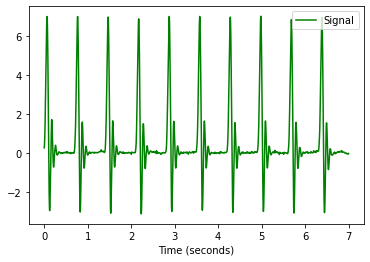

In [ ]:
import time
start = time.time()
print(inference('/content/u5.jpg'))
end = time.time()
print(end - start)